In [1]:
import pandas as pd


In [2]:
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")


In [25]:
trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,Date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02


In [26]:
sentiment.head()


,timestamp,value,classification,date,Date
0,1517463000,30,Fear,2018-02-01,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02,2018-02-02
2,1517635800,40,Fear,2018-02-03,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05,2018-02-05


In [27]:
#Fixing Trade and sentiment date (Timestamp IST)
trades['Timestamp IST'] = pd.to_datetime(
    trades['Timestamp IST'],
    dayfirst=True,
    errors='coerce'
)

trades['Date'] = trades['Timestamp IST'].dt.date

sentiment['Date'] = pd.to_datetime(
    sentiment['timestamp'],
    unit='s'
).dt.date

In [29]:
#Keeping only required columns
trades_clean = trades[
    ['Account', 'Coin', 'Side', 'Execution Price', 'Size USD', 'Closed PnL', 'Date']
].copy()

sentiment_clean = sentiment[
    ['Date', 'classification']
].copy()


In [32]:
# Merging Trades with Sentiment
merged_df = pd.merge(
    trades_clean,
    sentiment_clean,
    on='Date',
    how='left'
)


In [33]:
merged_df['classification'].value_counts()


classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64

In [34]:
avg_pnl = merged_df.groupby('classification')['Closed PnL'].mean()
avg_pnl #Average PnL by market sentiment


classification
Extreme Fear     34.537862
Extreme Greed    67.892861
Fear             54.290400
Greed            42.743559
Neutral          34.307718
Name: Closed PnL, dtype: float64

In [35]:
trade_count = merged_df['classification'].value_counts()
trade_count #Number of trades per sentiment


classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64

In [36]:
# Win vs Loss analysis
merged_df['Result'] = merged_df['Closed PnL'].apply(
    lambda x: 'Win' if x > 0 else 'Loss'
)

win_loss = merged_df.groupby(['classification', 'Result']).size()
win_loss


classification  Result
Extreme Fear    Loss      13469
                Win        7931
Extreme Greed   Loss      21398
                Win       18594
Fear            Loss      35818
                Win       26019
Greed           Loss      30945
                Win       19358
Neutral         Loss      22725
                Win       14961
dtype: int64

In [14]:
daily = merged_df.groupby('Date').agg(
    trades_count = ('Closed PnL','count'),
    total_pnl = ('Closed PnL','sum'),
    avg_pnl = ('Closed PnL','mean'),
    avg_size = ('Size USD','mean'),
    pnl_std = ('Closed PnL','std')
).reset_index()

daily = daily.merge(sentiment_clean, on='Date', how='left')
daily.head()


,Date,trades_count,total_pnl,avg_pnl,avg_size,pnl_std,classification
0,2023-05-01,3,0.000000,0.000000,159.000000,0.000000,Greed
1,2023-12-05,9,0.000000,0.000000,5556.203333,0.000000,Extreme Greed
2,2023-12-14,11,-205.434737,-18.675885,10291.213636,179.663534,Greed
3,2023-12-15,2,-24.632034,-12.316017,5304.975000,4.474304,Greed
4,2023-12-16,3,0.000000,0.000000,5116.256667,0.000000,Greed


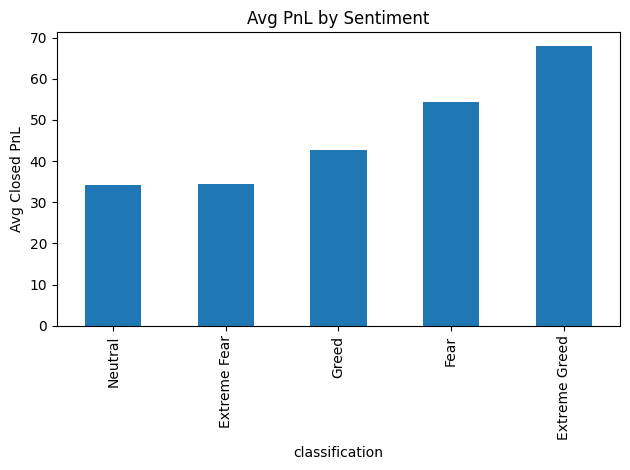

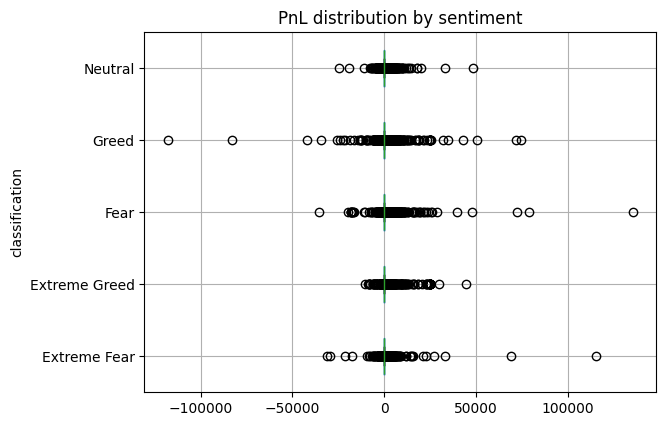

In [15]:
import matplotlib.pyplot as plt

# Avg PnL by sentiment
avg_pnl = merged_df.groupby('classification')['Closed PnL'].mean().sort_values()
avg_pnl.plot(kind='bar', ylabel='Avg Closed PnL', title='Avg PnL by Sentiment')
plt.tight_layout()
plt.show()

# Boxplot
merged_df.boxplot(column='Closed PnL', by='classification', vert=False)
plt.title('PnL distribution by sentiment')
plt.suptitle('')
plt.show()


In [37]:
#Win rate & trade sizing per sentiment
merged_df['is_win'] = merged_df['Closed PnL'] > 0

summary = merged_df.groupby('classification').agg(
    trades=('Closed PnL','count'),
    win_rate=('is_win','mean'),
    median_size=('Size USD','median'),
    avg_pnl=('Closed PnL','mean')
).sort_values('trades', ascending=False)

summary


,trades,win_rate,median_size,avg_pnl
classification,,,,
Fear,61837,0.420768,735.960,54.290400
Greed,50303,0.384828,555.000,42.743559
Extreme Greed,39992,0.464943,500.050,67.892861
Neutral,37686,0.396991,547.655,34.307718
Extreme Fear,21400,0.370607,766.150,34.537862


Trading Behavior Analysis

In [38]:
merged_df['is_win'] = merged_df['Closed PnL'] > 0

behavior_summary = merged_df.groupby('classification').agg(
    total_trades=('Closed PnL', 'count'),
    avg_trade_size=('Size USD', 'mean'),
    win_rate=('is_win', 'mean'),
    avg_pnl=('Closed PnL', 'mean')
)

behavior_summary


,total_trades,avg_trade_size,win_rate,avg_pnl
classification,,,,
Extreme Fear,21400,5349.731843,0.370607,34.537862
Extreme Greed,39992,3112.251565,0.464943,67.892861
Fear,61837,7816.109931,0.420768,54.290400
Greed,50303,5736.884375,0.384828,42.743559
Neutral,37686,4782.732661,0.396991,34.307718


Risk & Consistency Analysis

In [39]:
risk_summary = merged_df.groupby('classification').agg(
    pnl_volatility=('Closed PnL', 'std'),
    median_pnl=('Closed PnL', 'median'),
    worst_loss=('Closed PnL', 'min')
)

risk_summary


,pnl_volatility,median_pnl,worst_loss
classification,,,
Extreme Fear,1136.056091,0.0,-31036.69194
Extreme Greed,766.828294,0.0,-10259.46800
Fear,935.355438,0.0,-35681.74723
Greed,1116.028390,0.0,-117990.10410
Neutral,517.122220,0.0,-24500.00000
